<a href="https://colab.research.google.com/github/EthanJTucker/DTSA_5511_HW/blob/main/Week3_CNN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DTSA-5511: Week 3 
## CNN Cancer Detection Kaggle Mini-Project

### 11/20/2022


## Overview / Description of the problem and data

For this project, I use CNN to participate Kaggle competition: Histopathologic Cancer Detection [https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview]. The goal of this project is predicting these labels of test images with the CNN model. The data of this project are mainly RGB images, and labels of the training data. The data are split into two classes to classify whether the images  of cells have cancer. The total combined of training data, test data, and labels are large and would be downloaded as an zip file from kaggle. According to the download page of Kaggle, all the individual image files are .tif format with shape: 96, 96, 3. 


# Data Loading



In [57]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import cv2 
from PIL import Image
import sys
import os 
import zipfile
import shutil
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import io
from tensorflow.keras import datasets, layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread 
import datetime
import seaborn as sns
import matplotlib
import warnings
import os
from PIL import Image, ImageDraw
import shutil
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten

Download the data from the [Kaggle competition](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) to google drive,and mount into google colab. 

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
%%capture
!unzip "drive/MyDrive/histopathologic-cancer-detection.zip"

In [60]:
os.listdir(".") 

['.config',
 'train',
 'pngContainer',
 'His_New',
 'drive',
 'test',
 'sample_submission.csv',
 'Hist_New',
 'train_labels.csv',
 'sample_data']

In [61]:
! nvidia-smi

Tue Nov 22 09:19:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    31W /  70W |   1138MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [62]:
train_label = pd.read_csv('train_labels.csv')

In [63]:
train_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [64]:
train_label['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [65]:

Positive, Nagetive = train_label['label'].value_counts()
print(round((Nagetive/len(train_label))*100,1),"% images marked 0.")
print(round((Positive/len(train_label))*100,1),"% images marked 1.")

40.5 % images marked 0.
59.5 % images marked 1.


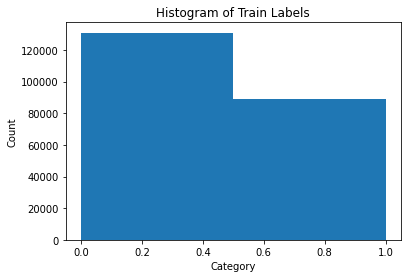

In [66]:

plt.hist(training_labels, bins = 2)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Histogram of Train Labels")
plt.show()

In total, there are 220,025 training samples in the dataset, and 89,117 trainning samples are posiitive which means these positive samples at least one pixel in image contains tumorous tissue. I chose to use 80% for training, and 20% for validation in this project.

In [67]:
def NewPNG(New, Old, fileName):
 
  Path = New + fileName[:-4] + ".png"
  this_img = Image.open(Old + fileName)
  this_img.save(Path)
  this_img.close()

In [98]:
train_0 = "./Hist_New/Train_New/0/"
train_1 = "./Hist_New/Train_New/1/"

os.makedirs(train_0)
os.makedirs(train_1)

training_labels = list(pd.read_csv("./train_labels.csv").sort_values(by = "id", axis = 0)["label"])
Train = "./train/"
Images_train = os.listdir(Train)
Images_train.sort()
assert len(Images_train) == len(training_labels)
for i in range(len(Images_train)):
  if training_labels[i] == 0:
    NewPNG(train_0, Train, Images_train[i])
  else:
    assert training_labels[i] == 1
    NewPNG(train_1, Train, Images_train[i])

In [99]:

train_data = tf.keras.utils.image_dataset_from_directory(
    directory = "/content/Hist_New/Train_New",
    labels = "inferred",
    label_mode = "binary",
    color_mode = "rgb",
    image_size = (96, 96),
    seed = 42,
    batch_size = 32
)

Found 220025 files belonging to 2 classes.


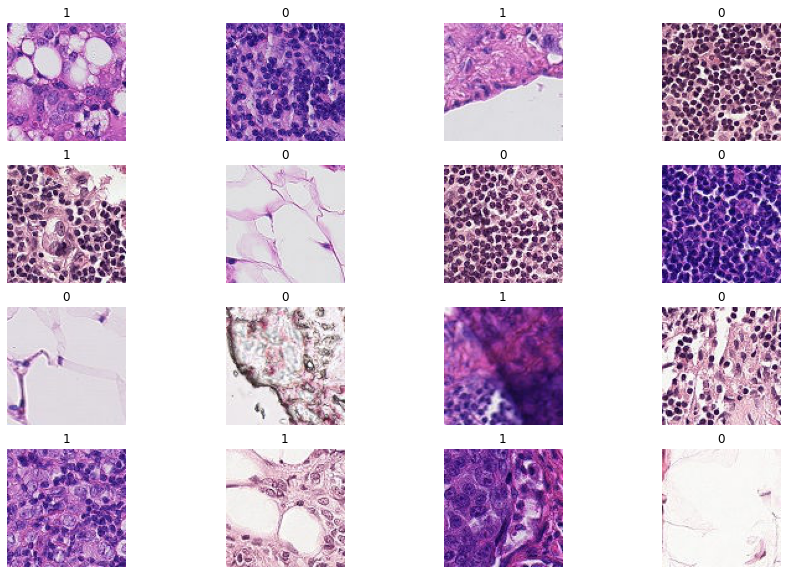

In [71]:


plt.figure(figsize=(15, 10))
for images, names in train_data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(names[i]))
        plt.axis("off")



# Model Architecture



In [75]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = (96, 96, 3)),
    tf.keras.layers.Dense(10),
])

In [76]:


model = tf.keras.models.Sequential()
model.add(Conv2D(16,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(32,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

 

model.compile(optimizer = keras.optimizers.Adam(0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy']) 


In [77]:
callback = EarlyStopping(monitor='val_loss', patience = 3)
Reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3)
history = model.fit(train_data,
                      steps_per_epoch = len(train_data)/100,
                    epochs = 20,
                    callbacks = [callback, Reduce_lr])



Epoch 1/20
69/68 [==============================] - ETA: 0s - loss: 0.9002 - accuracy: 0.7138

68/68 [==============================] - 8s 89ms/step - loss: 0.9002 - accuracy: 0.7138 - lr: 0.0010
Epoch 2/20
69/68 [==============================] - ETA: 0s - loss: 0.5583 - accuracy: 0.7554

68/68 [==============================] - 6s 87ms/step - loss: 0.5583 - accuracy: 0.7554 - lr: 0.0010
Epoch 3/20
69/68 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.7885

68/68 [==============================] - 6s 81ms/step - loss: 0.4822 - accuracy: 0.7885 - lr: 0.0010
Epoch 4/20
69/68 [==============================] - ETA: 0s - loss: 0.4663 - accuracy: 0.7885

68/68 [==============================] - 6s 81ms/step - loss: 0.4663 - accuracy: 0.7885 - lr: 0.0010
Epoch 5/20
69/68 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.8075

68/68 [==============================] - 5s 72ms/step - loss: 0.4579 - accuracy: 0.8075 - lr: 0.0010
Epoch 6/20
69/68 [==============================] - ETA: 0s - loss: 0.4470 - accuracy: 0.7930

68/68 [==============================] - 5s 68ms/step - loss: 0.4470 - accuracy: 0.7930 - lr: 0.0010
Epoch 7/20
69/68 [==============================] - ETA: 0s - loss: 0.4672 - accuracy: 0.7953

68/68 [==============================] - 5s 70ms/step - loss: 0.4672 - accuracy: 0.7953 - lr: 0.0010
Epoch 8/20
69/68 [==============================] - ETA: 0s - loss: 0.4366 - accuracy: 0.8089

68/68 [==============================] - 5s 67ms/step - loss: 0.4366 - accuracy: 0.8089 - lr: 0.0010
Epoch 9/20
69/68 [==============================] - ETA: 0s - loss: 0.4143 - accuracy: 0.8274

68/68 [==============================] - 4s 65ms/step - loss: 0.4143 - accuracy: 0.8274 - lr: 0.0010
Epoch 10/20
69/68 [==============================] - ETA: 0s - loss: 0.4079 - accuracy: 0.8234

68/68 [==============================] - 5s 70ms/step - loss: 0.4079 - accuracy: 0.8234 - lr: 0.0010
Epoch 11/20
69/68 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.8265

68/68 [==============================] - 5s 69ms/step - loss: 0.4011 - accuracy: 0.8265 - lr: 0.0010
Epoch 12/20
69/68 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8356

68/68 [==============================] - 5s 74ms/step - loss: 0.3998 - accuracy: 0.8356 - lr: 0.0010
Epoch 13/20
69/68 [==============================] - ETA: 0s - loss: 0.4030 - accuracy: 0.8207

68/68 [==============================] - 6s 90ms/step - loss: 0.4030 - accuracy: 0.8207 - lr: 0.0010
Epoch 14/20
69/68 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.8184

68/68 [==============================] - 6s 92ms/step - loss: 0.3813 - accuracy: 0.8184 - lr: 0.0010
Epoch 15/20
69/68 [==============================] - ETA: 0s - loss: 0.3785 - accuracy: 0.8333

68/68 [==============================] - 6s 83ms/step - loss: 0.3785 - accuracy: 0.8333 - lr: 0.0010
Epoch 16/20
69/68 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8361

68/68 [==============================] - 6s 80ms/step - loss: 0.3695 - accuracy: 0.8361 - lr: 0.0010
Epoch 17/20
69/68 [==============================] - ETA: 0s - loss: 0.4013 - accuracy: 0.8225

68/68 [==============================] - 5s 71ms/step - loss: 0.4013 - accuracy: 0.8225 - lr: 0.0010
Epoch 18/20
69/68 [==============================] - ETA: 0s - loss: 0.3779 - accuracy: 0.8302

68/68 [==============================] - 4s 61ms/step - loss: 0.3779 - accuracy: 0.8302 - lr: 0.0010
Epoch 19/20
69/68 [==============================] - ETA: 0s - loss: 0.4209 - accuracy: 0.8148

68/68 [==============================] - 4s 60ms/step - loss: 0.4209 - accuracy: 0.8148 - lr: 0.0010
Epoch 20/20
69/68 [==============================] - ETA: 0s - loss: 0.3937 - accuracy: 0.8288

68/68 [==============================] - 4s 62ms/step - loss: 0.3937 - accuracy: 0.8288 - lr: 0.0010


In [78]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 48, 48, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                      


## Results and Analysis

When training the model, I choose several various hyperparameters and different learning rate during tunning. From the below list, we can see the accuracy rate after trainning the CNN can reach above 80%. I also visualize and caompare both of accuracy and loss with epoch in order to show the trend while traning epochs in the CNN model.


In [79]:
history.history

{'loss': [0.9001608490943909,
  0.5583357810974121,
  0.4821763038635254,
  0.4662896394729614,
  0.4578930735588074,
  0.44702816009521484,
  0.4672170877456665,
  0.4365665912628174,
  0.41430017352104187,
  0.4078817367553711,
  0.4010976552963257,
  0.39983031153678894,
  0.402957022190094,
  0.3813217878341675,
  0.37851566076278687,
  0.36953529715538025,
  0.4013116955757141,
  0.37792885303497314,
  0.42088833451271057,
  0.39366957545280457],
 'accuracy': [0.7137681245803833,
  0.7554348111152649,
  0.7884963750839233,
  0.7884963750839233,
  0.8075181245803833,
  0.7930253744125366,
  0.7952898740768433,
  0.8088768124580383,
  0.8274456262588501,
  0.823369562625885,
  0.8265398740768433,
  0.835597813129425,
  0.820652186870575,
  0.8183876872062683,
  0.8333333134651184,
  0.8360507488250732,
  0.8224637508392334,
  0.8301630616188049,
  0.8147644996643066,
  0.8288043737411499],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001

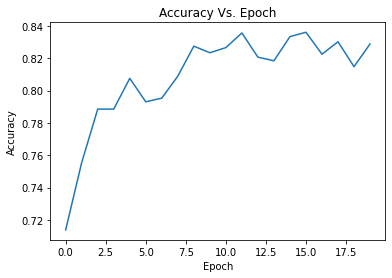

In [80]:

Accurac = history.history["accuracy"]
epochs = [i for i in range(len(Accurac))]
plt.plot(epochs, Accurac)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Epoch")
plt.show()

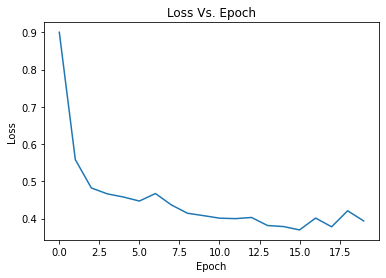

In [81]:

Losses = history.history["loss"]
plt.plot(epochs, Losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Vs. Epoch")
plt.show()

In [83]:
from pandas._libs.algos import take_2d_axis0_int16_int16

dirTestTarget = "./Hist_New/Test_New/Images"

#os.makedirs(dirTestTarget)
test_1 = "./test/"
Imgs_T = os.listdir(test_1)
Imgs_T.sort()

for i in Imgs_T:
  NewPNG(dirTestTarget, test_1, i)

test_data = tf.keras.utils.image_dataset_from_directory(
    directory = "/content/Hist_New/Test_New",
    labels = None,
    label_mode = "binary",
    color_mode = "rgb",
    image_size = (96, 96),
    batch_size = 32
)

Found 57458 files belonging to 1 classes.


In [91]:
PreRes = model.predict(test_data)


1796/1796 [==============================] - 35s 20ms/step


In [93]:
label = [(PreRes[i]) for i in range(len(PreRes))]
id = [test_data.file_paths[i][35:-4] for i in range(len(test_data.file_paths))]
PreD = {"id" : id,"label" : label}
Res = pd.DataFrame(PreD)

In [97]:
Res.to_csv("./submission.csv",index = False)

# Conclusion

In order to use GPU for the large dataset I download, I choose to use Google collab to work on this CNN project. For training and tunning the CNN model, I try to change the architecture of the model and tune the parameters to find out better results. I think the only issue about tunning model is the time consuming. Moreover, the performance of the model works fine, and trying different parameters helps a lot for find best result of model. I feel the biggest issue I experience in this project is google collab always ask me to reload the data and retrain the model especially during tunning and traning model. That's why I'm unable to train the model with much more epochs. After this project, I would like to train model in a computer with GPU in future assignments.


